In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque  
from mlagents_envs.environment import UnityEnvironment

### Create DDPG agent!

In [3]:
N_STATES  = 210  # 105+105
N_ACTIONS = 1  # 1 branch with 7 values, move forward/backward, rotate R/L, move R/L 
N_AGENTS = 3

In [4]:
BUFFER_SIZE = int(1e3) #int(1e5)        # replay buffer size
BATCH_SIZE =  32   #128              # minibatch size
GAMMA = 0.99                  # discount factor
TAU = 1e-3                    # for soft update of target parameters
LR_ACTOR = 1e-4               # learning rate of the actor 
LR_CRITIC = 1e-4              # learning rate of the critic
WEIGHT_DECAY = 0.0            # L2 weight decay

In [5]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else: 
    device= torch.device("cpu")
    print(device)

cuda GeForce GTX 1660 SUPER


In [6]:
# load NN, reply buffer, and Agent class
%run "9. DDPG_NN_and_MemoryBuffer.ipynb"   
%run "9. DDPG_Agent.ipynb"       

In [32]:
agent = Agent(state_size=N_STATES, action_size=N_ACTIONS, num_agents=N_AGENTS, random_seed=0)

# Let's begin training!

In [11]:
# define a function to convert action value [-1, 1] to index 0~6
def GenerateActionIndex(acts):
    result = []
    for AgentIdx in range(N_AGENTS):
        value = acts[AgentIdx][0]
        interval = 2/7
        lower = -1
        for i in range(7):  #action index 0~6
            upper = lower + (i+1)*interval
            if(value >= lower and value <= upper):
                result.append([i])
                break
            else:
                lower = upper
    return result

In [27]:
env = UnityEnvironment(file_name= None, base_port=5004)

In [28]:
env.reset()
behaviorNames = list(env.behavior_specs.keys())
behaviorName = behaviorNames[0]
print(behaviorName)

PushBlock?team=0


In [29]:
num_episodes= 50  #5000

In [30]:
episode_scores = []            #historical scores
scores_average_window = 100    #Window size to calculate avg score    
solved_score = 8               #avg score required to consider finished

In [36]:
# loop from num_episodes
for i_episode in range(1, num_episodes+1):
    # reset the unity environment at the beginning of each episode
    env.reset()    

    # get initial state of the unity environment 
    DecisionSteps, TerminalSteps = env.get_steps(behaviorName)
    s1 = DecisionSteps.obs[0]
    s2 = DecisionSteps.obs[1]
    states = np.concatenate((s1, s2), 1)
    
	# reset the training agent for new episode
    agent.reset()

    # set the initial episode score to zero.
    agent_scores = np.zeros(N_AGENTS)

    # Run the episode training loop;
    # At each loop step take an action as a function of the current state observations
    # Based on the resultant environmental state (next_state) and reward received update the Agents Actor and Critic networks
    # If environment episode is done, exit loop...
    # Otherwise repeat until done == true 
    while (True):
        # determine actions for the unity agents from current sate
        actions = agent.act(states)

        # send the actions to the unity agents in the environment and receive resultant environment information
        ActionIdxArray = np.array(GenerateActionIndex(actions))
        env.set_actions(behaviorName, ActionIdxArray)
        env.step()

        # get next states
        NextDecisionSteps, NextTerminalSteps = env.get_steps(behaviorName)
        
        #if next decision step misses some agents, then exit episode loop, to begin new episode
        if(len(NextDecisionSteps)!= N_AGENTS): 
            break
        
        # else next decision step contains all agents
        s1 = NextDecisionSteps.obs[0]
        s2 = NextDecisionSteps.obs[1]
        next_states = np.concatenate((s1, s2), 1)
        
        dones = np.array([[0]]*N_AGENTS)
        for AgentID in  NextTerminalSteps.agent_id:
            dones[AgentID] = 1                
        
        rewards = NextDecisionSteps.reward
        
        #Send (S, A, R, S') info to the training agent for replay buffer (memory) and network updates
        agent.step(states, ActionIdxArray, rewards, next_states, dones)

        # set new states to current states for determining next actions
        states = next_states

        # Update episode score for each unity agent
        agent_scores += rewards
        
        #if next terminal step contains some agents, we also exit episode loop
        if(len(NextTerminalSteps) > 0): 
            break

    # Add episode score to Scores and...
    # Calculate mean score over last 100 episodes 
    # Mean score is calculated over current episodes until i_episode > 100
    episode_scores.append(np.mean(agent_scores))
    average_score = np.mean(episode_scores[i_episode-min(i_episode,scores_average_window):i_episode+1])

    #Print current and average score
    print('\nEpisode {}\tEpisode Score: {:.3f}\tAverage Score: {:.3f}'.format(i_episode, episode_scores[i_episode-1], average_score), end="")
    


Episode 1	Episode Score: -0.346	Average Score: -0.346
Episode 2	Episode Score: -1.000	Average Score: -0.673
Episode 3	Episode Score: -0.173	Average Score: -0.506
Episode 4	Episode Score: -1.000	Average Score: -0.630
Episode 5	Episode Score: -1.000	Average Score: -0.704
Episode 6	Episode Score: -0.079	Average Score: -0.600
Episode 7	Episode Score: -1.000	Average Score: -0.657
Episode 8	Episode Score: -1.000	Average Score: -0.700
Episode 9	Episode Score: -1.000	Average Score: -0.733
Episode 10	Episode Score: -0.221	Average Score: -0.682
Episode 11	Episode Score: -1.000	Average Score: -0.711
Episode 12	Episode Score: -1.000	Average Score: -0.735
Episode 13	Episode Score: -1.000	Average Score: -0.755
Episode 14	Episode Score: -1.000	Average Score: -0.773
Episode 15	Episode Score: -1.000	Average Score: -0.788
Episode 16	Episode Score: -0.034	Average Score: -0.741
Episode 17	Episode Score: -1.000	Average Score: -0.756
Episode 18	Episode Score: -0.880	Average Score: -0.763
Episode 19	Episode

KeyboardInterrupt: 

In [37]:
env.close()

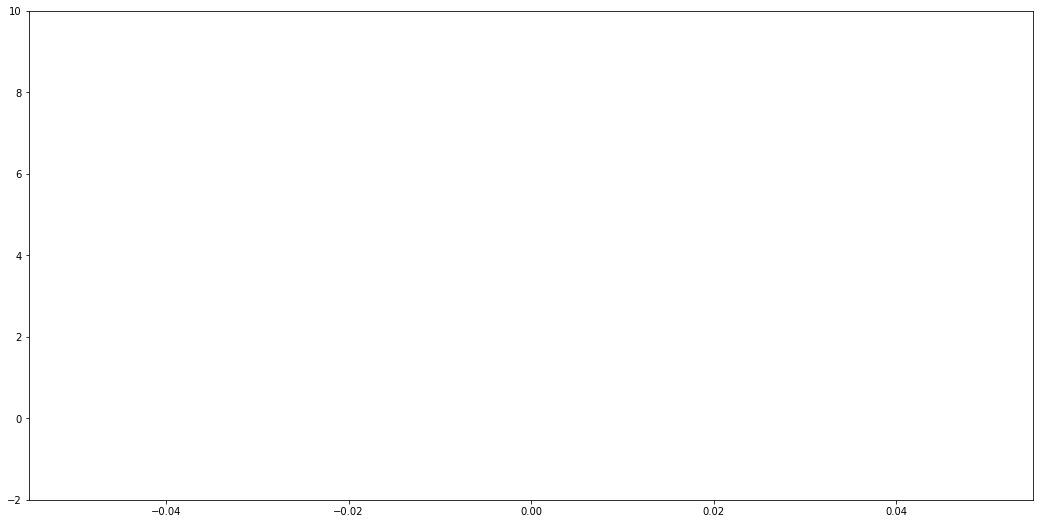

In [38]:
plt.figure(figsize=(18,9))
plt.plot(episode_scores[10000:])
plt.ylim(-2, 10)
plt.show()

In [25]:
# Save trained  Actor and Critic network weights 
torch.save(agent.actor_local.state_dict(),  "ddpgActor.pth")
torch.save(agent.critic_local.state_dict(), "ddpgCritic.pth")